<a href="https://colab.research.google.com/github/UoR-Vision/VisualDota/blob/main/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

***
<a id="colab"></a>
## Adapting to the Colab Operating Environment

In Colab environment, it is neccessary to download the whole project from Github.

In [2]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    print("Running in Google Colab!")
    !git clone https://github.com/UoR-Vision/VisualDota.git -b main
    %cd VisualDota/src
    from google.colab import drive
    drive.mount('/content/drive')
    DATASET_ROOT_DIR = '/content/drive/MyDrive/VisualDota/DOTA'
    MODEL_ROOT_DIR = '/content/drive/MyDrive/VisualDota/models'
else:
    print("Not running in Colab.")
    DATASET_ROOT_DIR = './data'
    MODEL_ROOT_DIR = '../models'

Running in Google Colab!
Cloning into 'VisualDota'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 115 (delta 41), reused 25 (delta 10), pack-reused 38 (from 2)
Receiving objects: 100% (115/115), 136.98 MiB | 34.44 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/VisualDota/src/VisualDota/src
Mounted at /content/drive


***
<a id="hotload"></a>
## Hot Loading .py File

Here is to import custom .py file. It can be hot-loaded, just re-run the following cell.

Documentation comments are provided for each public function. To check the comments please use the help() function.

In [3]:
try:
    import importlib
except:
    !pip install importlib
    import importlib

In [4]:
try:
    import data_loader # import data loader for data training
    import data_process  # import data_process for data pre-processing
    import modeling_faster_rcnn # import faster-rcnn model
    import visual_utils  # import visual utils for visualization

except ModuleNotFoundError as e:
    print(f'[ERROR] fail to import a custom module at path: {os.path.abspath(".")}, msg: {e}.')
except Exception as e:
    print(f'[ERROR] fail to read module at path: {os.path.abspath(".")}, msg: {e}')
else:
    # Hot loading python files
    importlib.reload(data_loader)
    importlib.reload(data_process)
    importlib.reload(modeling_faster_rcnn)
    importlib.reload(visual_utils)

***
<a id="import"></a>
## Import libraries

To import the required libraries for whole project.

In [5]:
# import the build-in required libraries
import os
import warnings

# import the third-part required libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from zipfile import ZipFile
from collections import defaultdict

# check the versions of third-part libraries
print(f'matplotlib: {matplotlib.__version__}, numpy: {np.__version__}')

matplotlib: 3.10.0, numpy: 2.0.2


# 2 Data Selection & Preprocessing

## Load Dataset

In [ ]:
dataset = data_process.load_dataset()
len(dataset)

In [ ]:
visual_utils.visualize_images(dataset)

In [ ]:
labels = data_process.count_labels()
labels

# 3 Exploratory data analysis

## 3.1 Object Category Distribution

In [6]:
zip_path = os.path.abspath("./data/labelTxt.zip")

category_counts = Counter()

with ZipFile(zip_path, 'r') as zip_file:
    for file_name in zip_file.namelist():
        if file_name.endswith('.txt'):
            with zip_file.open(file_name) as file:
                for line in file:
                    try:
                        parts = line.decode('utf-8').strip().split()
                        if len(parts) >= 10:
                            category = parts[8].strip()
                            category_counts[category] += 1
                    except Exception as e:
                        print(f"[ERROR] {file_name}: {e}")

# Convert to DataFrame
df_counts = pd.DataFrame(category_counts.items(), columns=["Category", "Count"])
df_counts = df_counts.sort_values(by="Count", ascending=False)

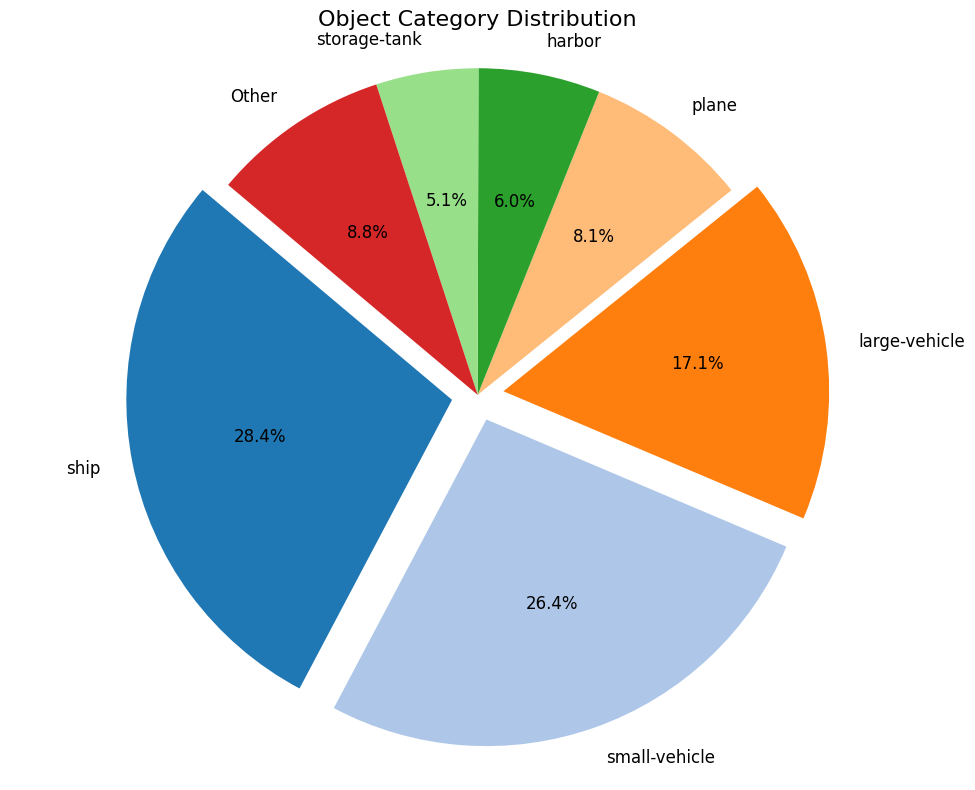

In [7]:
# Parameters
top_n = 6  # how many categories to show individually
colors = plt.cm.tab20.colors  # colorful palette

# Group small categories as 'Other'
df_counts_top = df_counts.head(top_n).copy()
other = df_counts.iloc[top_n:]["Count"].sum()
df_counts_top.loc[len(df_counts_top)] = ["Other", other]

# Create labels and data
labels = df_counts_top["Category"]
sizes = df_counts_top["Count"]

# Explode top 3 slightly
explode = [0.08 if i < 3 else 0 for i in range(len(sizes))]

# Plot
plt.figure(figsize=(10, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    explode=explode,
    colors=colors[:len(sizes)],
    textprops={'fontsize': 12}
)
plt.title("Object Category Distribution", fontsize=16)
plt.axis("equal")
plt.tight_layout()
plt.show()

## 3.2 Percentage of Difficult Annotations Per Category

In [8]:
# Initialize counters
category_total = defaultdict(int)
category_difficult = defaultdict(int)

# Parse the zip
with ZipFile(zip_path, 'r') as zip_file:
    for file_name in zip_file.namelist():
        if file_name.endswith('.txt'):
            with zip_file.open(file_name) as file:
                for line in file:
                    try:
                        parts = line.decode('utf-8').strip().split()
                        if len(parts) >= 10:
                            category = parts[8].strip()
                            difficult = parts[-1].strip()
                            category_total[category] += 1
                            if difficult == '1':
                                category_difficult[category] += 1
                    except Exception as e:
                        print(f"[ERROR] {file_name}: {e}")

In [9]:
# Combine into DataFrame
df_difficulty = pd.DataFrame({
    'Category': category_total.keys(),
    'Total': [category_total[c] for c in category_total],
    'Difficult': [category_difficult.get(c, 0) for c in category_total]
})

# Add % column
df_difficulty['Difficult %'] = (df_difficulty['Difficult'] / df_difficulty['Total']) * 100

# Sort by descending % of difficulty
df_difficulty = df_difficulty.sort_values(by='Difficult %', ascending=False)
df_difficulty.reset_index(drop=True, inplace=True)
df_difficulty.head()

,Category,Total,Difficult,Difficult %
0,soccer-ball-field,326,120,36.809816
1,storage-tank,5029,1005,19.984092
2,ground-track-field,325,36,11.076923
3,small-vehicle,26126,2646,10.127842
4,basketball-court,515,52,10.097087


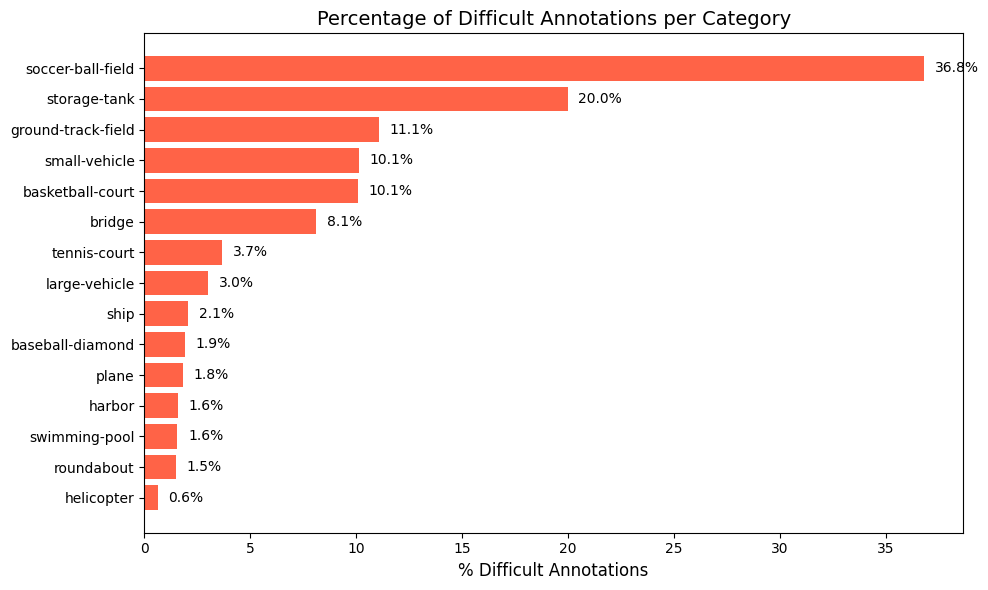

In [10]:
# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(df_difficulty['Category'], df_difficulty['Difficult %'], color='tomato')
plt.xlabel('% Difficult Annotations', fontsize=12)
plt.title('Percentage of Difficult Annotations per Category', fontsize=14)

# Add text labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', va='center', fontsize=10)

plt.gca().invert_yaxis()  # highest % on top
plt.tight_layout()
plt.show()

## 3.3 Object Bounding Box Sizes Per Category

In [11]:
# Shoelace formula for quadrilateral area
def polygon_area(x, y):
    return 0.5 * abs(sum(x[i]*y[(i+1)%4] - x[(i+1)%4]*y[i] for i in range(4)))

# Collect areas per category
category_areas = defaultdict(list)

with ZipFile(zip_path, 'r') as zip_file:
    for file_name in zip_file.namelist():
        if file_name.endswith('.txt'):
            with zip_file.open(file_name) as file:
                for line in file:
                    try:
                        parts = line.decode('utf-8').strip().split()
                        if len(parts) >= 10:
                            x_coords = list(map(float, parts[0:8:2]))  # x1, x2, x3, x4
                            y_coords = list(map(float, parts[1:8:2]))  # y1, y2, y3, y4
                            area = polygon_area(x_coords, y_coords)
                            category = parts[8].strip()
                            category_areas[category].append(area)
                    except Exception as e:
                        print(f"[ERROR] {file_name}: {e}")

In [12]:
# Flatten into long-form DataFrame
records = []
for category, areas in category_areas.items():
    for area in areas:
        records.append({'Category': category, 'Area': area})

df_area = pd.DataFrame(records)

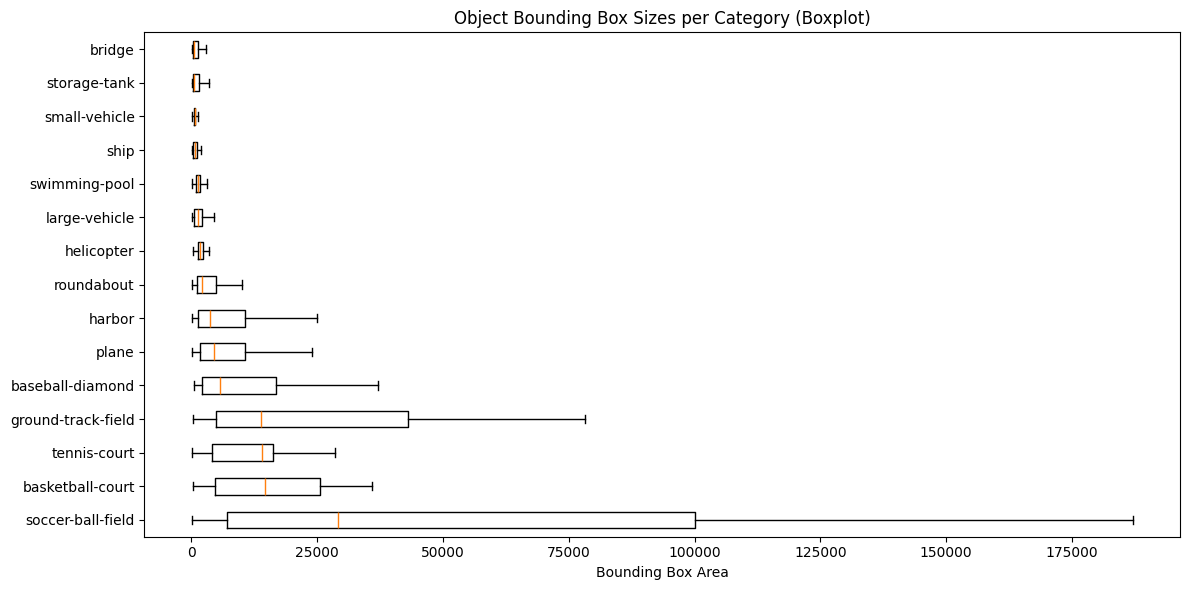

In [13]:
# Plotting
plt.figure(figsize=(12, 6))
sorted_categories = df_area.groupby("Category")["Area"].median().sort_values(ascending=False).index
df_area_sorted = df_area.copy()
df_area_sorted["Category"] = pd.Categorical(df_area_sorted["Category"], categories=sorted_categories)

plt.boxplot(
    [df_area_sorted[df_area_sorted["Category"] == cat]["Area"] for cat in sorted_categories],
    tick_labels=sorted_categories,
    showfliers=False,
    vert=False
)

# Add text labels to bars
plt.xlabel("Bounding Box Area")
plt.title("Object Bounding Box Sizes per Category (Boxplot)")
plt.tight_layout()
plt.show()

# 4 Modelling

## 4.3 Faster Region-based Convolutional Neural Network (Faster RCNN)

### 4.3.1 Summary of Faster RCNN

In [ ]:
# Faster-RCNN model
faster_rcnn = modeling_faster_rcnn.load_model(
    model_name='fasterrcnn_v13.pth',
    # init=True,
    root=MODEL_ROOT_DIR,
)

load from local model: ../models\fasterrcnn_v3.pth


### 4.3.2 Model Training and Evaluation

In [ ]:
# Data Loader for Faster-RCNN
faster_rcnn_data_loader = data_loader.faster_rcnn_data_loader(
    image_dir=os.path.join(DATASET_ROOT_DIR, 'tiny_train/images'),
    label_dir=os.path.join(DATASET_ROOT_DIR, 'tiny_train/labels'),
    batch_size=20,
    num_workers=3,
)
for i in range(14, 20):
  # Train Faster-RCNN model
  modeling_faster_rcnn.train_model(
      faster_rcnn,
      data_loader=faster_rcnn_data_loader,
      epochs=2,
  )
  # Save Faster-RCNN model
  modeling_faster_rcnn.save_model(
      faster_rcnn,
      version=i,
      model_path=MODEL_ROOT_DIR,
  )
  # Predict and Visualize the results
  modeling_faster_rcnn.predict(
      faster_rcnn,
      image_path=os.path.join(DATASET_ROOT_DIR, 'tiny_train/images/P0002.png'),
      confidence_threshold=0.1,
      saved_img_path=os.path.join(DATASET_ROOT_DIR, 'tiny_train/results/P0002_v{i}.png')
  )

training faster-rcnn model
training interrupt: All bounding boxes should have positive height and width. Found invalid box [324.74884033203125, 683.2000122070312, 324.74884033203125, 702.4000244140625] for target at index 0.


In [ ]:
# faster_rcnn = None
# faster_rcnn_data_loader = None
import gc
import torch

gc.collect()
if torch.cuda.is_available():
  torch.cuda.empty_cache()

In [ ]:
# Save Faster-RCNN model
modeling_faster_rcnn.save_model(
    faster_rcnn,
    version=14,
    model_path=MODEL_ROOT_DIR,
)

### 4.3.3 Results and Discussion

In [ ]:
# Predict and Visualize the results
modeling_faster_rcnn.predict(
    faster_rcnn,
    image_path='data/train/images/P0002.png',
    confidence_threshold=0.1,
)

# 5 Evaluation

# Summary